In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the QVI_data (assumed to be the output from Task 1 cleanup)
try:
    data = pd.read_csv('/content/QVI_data.csv')
except FileNotFoundError:
    print("Error: QVI_data.csv not found. Please ensure the file is in the working directory.")
    exit()


In [3]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182720 entries, 0 to 182719
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    182720 non-null  int64  
 1   DATE              182720 non-null  object 
 2   STORE_NBR         182720 non-null  int64  
 3   TXN_ID            182720 non-null  int64  
 4   PROD_NBR          182720 non-null  int64  
 5   PROD_NAME         182720 non-null  object 
 6   PROD_QTY          182720 non-null  int64  
 7   TOT_SALES         182720 non-null  float64
 8   PACK_SIZE         182720 non-null  int64  
 9   BRAND             182720 non-null  object 
 10  LIFESTAGE         182720 non-null  object 
 11  PREMIUM_CUSTOMER  182719 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 16.7+ MB


In [5]:
# Ensure 'DATE' is a datetime object
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract month and year for monthly aggregation
data['YEAR_MONTH'] = data['DATE'].dt.to_period('M')

In [7]:
# Define trial configuration
TRIAL_STORES = [77, 86, 88]
# Define the trial period (Feb 2019 to Apr 2019 is a common 3-month trial period)
TRIAL_PERIOD_START = pd.to_datetime('2019-02-01').to_period('M')
TRIAL_PERIOD_END = pd.to_datetime('2019-04-30').to_period('M')
# Calculate the start and end of the pre-trial period (e.g., all data before Feb 2019)
PRE_TRIAL_END = TRIAL_PERIOD_START - 1

In [8]:
# Aggregate data by store and month for all required metrics
store_metrics_monthly = data.groupby(['STORE_NBR', 'YEAR_MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    customer_count=('LYLTY_CARD_NBR', 'nunique'),
    transaction_count=('TXN_ID', 'count')
).reset_index()


In [9]:
# Calculate average transactions per customer
store_metrics_monthly['avg_txns_per_cust'] = store_metrics_monthly['transaction_count'] / store_metrics_monthly['customer_count']

In [10]:
def select_control_store(trial_store_num, pre_trial_end_month):
    """
    Selects the best control store for a given trial store based on Pearson correlation
    of total monthly sales during the pre-trial period.
    """

    # 3.1 Identify potential control stores (all stores NOT in trial)
    # We exclude the trial store itself
    potential_controls = store_metrics_monthly[
        ~store_metrics_monthly['STORE_NBR'].isin(TRIAL_STORES)
    ]['STORE_NBR'].unique()

    # 3.2 Filter data to pre-trial period and Trial Store
    pre_trial_data = store_metrics_monthly[
        store_metrics_monthly['YEAR_MONTH'] <= pre_trial_end_month
    ].copy()

    # Get the sales time series for the trial store
    trial_store_sales = pre_trial_data[
        pre_trial_data['STORE_NBR'] == trial_store_num
    ].set_index('YEAR_MONTH')['total_sales']

    # 3.3 Find correlation for each potential control store
    correlation_results = {}

    for control_store_num in potential_controls:
        control_store_sales = pre_trial_data[
            pre_trial_data['STORE_NBR'] == control_store_num
        ].set_index('YEAR_MONTH')['total_sales']

        # Align series by month and drop months missing from either
        combined = pd.DataFrame({
            'trial': trial_store_sales,
            'control': control_store_sales
        }).dropna()

        # We need at least 2 common months to calculate correlation
        if len(combined) > 1:
            correlation = combined['trial'].corr(combined['control'], method='pearson')
            # Calculate a "magnitude distance" to ensure sales are similar in scale
            # We use the mean sales value in the pre-trial period
            trial_mean = combined['trial'].mean()
            control_mean = combined['control'].mean()
            magnitude_distance = abs(trial_mean - control_mean) / trial_mean # Percentage difference

            # Combine correlation (higher is better) and distance (lower is better)
            # We prioritize high correlation (weight 0.6) and low magnitude difference (weight 0.4)
            # The score is 0.6 * correlation - 0.4 * magnitude_distance
            score = 0.6 * correlation - 0.4 * magnitude_distance

            correlation_results[control_store_num] = {
                'correlation': correlation,
                'magnitude_distance_pct': magnitude_distance * 100,
                'selection_score': score
            }

    # 3.4 Select the store with the highest selection score
    if not correlation_results:
        return None, None

    best_control = max(correlation_results.items(), key=lambda item: item[1]['selection_score'])
    return best_control[0], correlation_results[best_control[0]]


In [11]:
control_store_map = {}
print("--- Control Store Selection Results (Pre-Trial Period) ---")
for trial_store in TRIAL_STORES:
    control_num, control_details = select_control_store(trial_store, PRE_TRIAL_END)
    control_store_map[trial_store] = control_num

    if control_details:
        print(f"Trial Store {trial_store} Control: {control_num}")
        print(f"  Correlation (Sales): {control_details['correlation']:.4f}")
        print(f"  Sales Difference: {control_details['magnitude_distance_pct']:.2f}%")
        print(f"  Selection Score: {control_details['selection_score']:.4f}\n")
    else:
        print(f"Trial Store {trial_store} - No suitable control found.\n")


--- Control Store Selection Results (Pre-Trial Period) ---
Trial Store 77 Control: 50
  Correlation (Sales): 0.9285
  Sales Difference: 17.17%
  Selection Score: 0.4884

Trial Store 86 Control: 155
  Correlation (Sales): 0.8779
  Sales Difference: 3.09%
  Selection Score: 0.5144

Trial Store 88 Control: 79
  Correlation (Sales): 0.7897
  Sales Difference: 22.92%
  Selection Score: 0.3821



--- Trial Performance Evaluation (Trial Period: Feb 2019 - Apr 2019) ---

--- Comparing Trial Store 77 vs. Control Store 50 ---
Pre-Trial T-Test P-Value (Sales): 0.0758
  Baseline OK: Pre-trial sales were not statistically different (P > 0.05).

Trial Period Sales (3 months):
  Trial Store 77 Sales: $777.00
  Control Store 50 Sales: $623.90
  SALES IMPACT (Trial vs Control): +24.54%
  Customer Count Impact: +17.36%
  Avg Txns Per Cust Impact: +0.23%


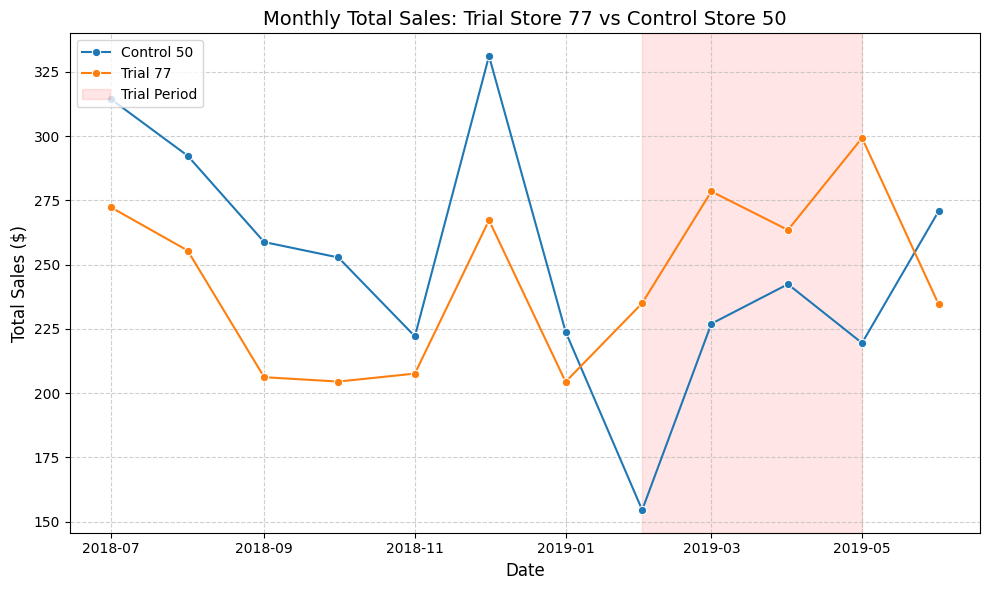

  Sales comparison plot saved as sales_comparison_store_77.png

--- Comparing Trial Store 86 vs. Control Store 155 ---
Pre-Trial T-Test P-Value (Sales): 0.4836
  Baseline OK: Pre-trial sales were not statistically different (P > 0.05).

Trial Period Sales (3 months):
  Trial Store 86 Sales: $2,788.20
  Control Store 155 Sales: $2,540.20
  SALES IMPACT (Trial vs Control): +9.76%
  Customer Count Impact: +13.54%
  Avg Txns Per Cust Impact: -2.41%


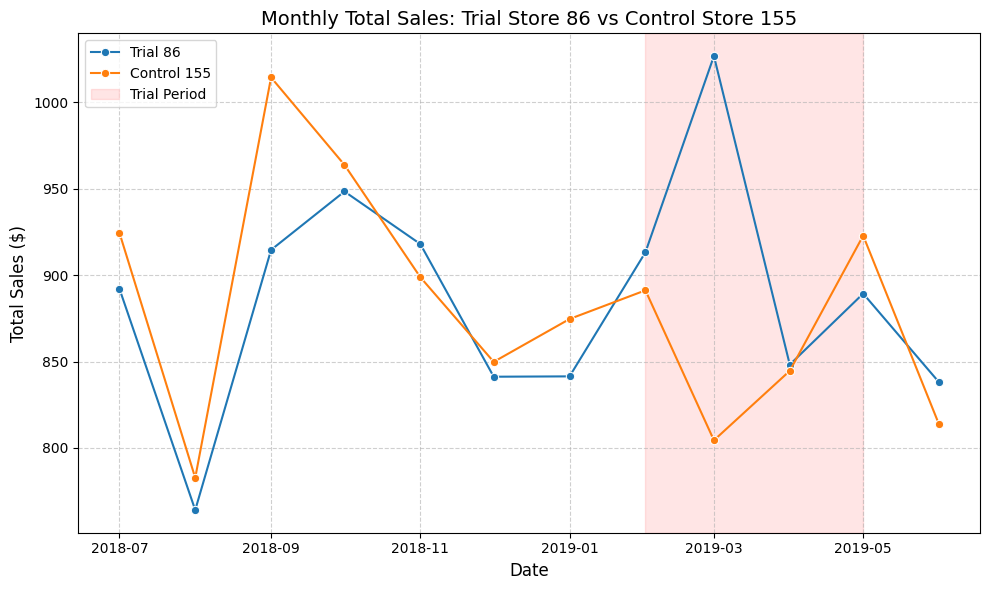

  Sales comparison plot saved as sales_comparison_store_86.png

--- Comparing Trial Store 88 vs. Control Store 79 ---
Pre-Trial T-Test P-Value (Sales): 0.0000

Trial Period Sales (3 months):
  Trial Store 88 Sales: $4,286.80
  Control Store 79 Sales: $2,897.50
  SALES IMPACT (Trial vs Control): +47.95%
  Customer Count Impact: +32.19%
  Avg Txns Per Cust Impact: +8.12%


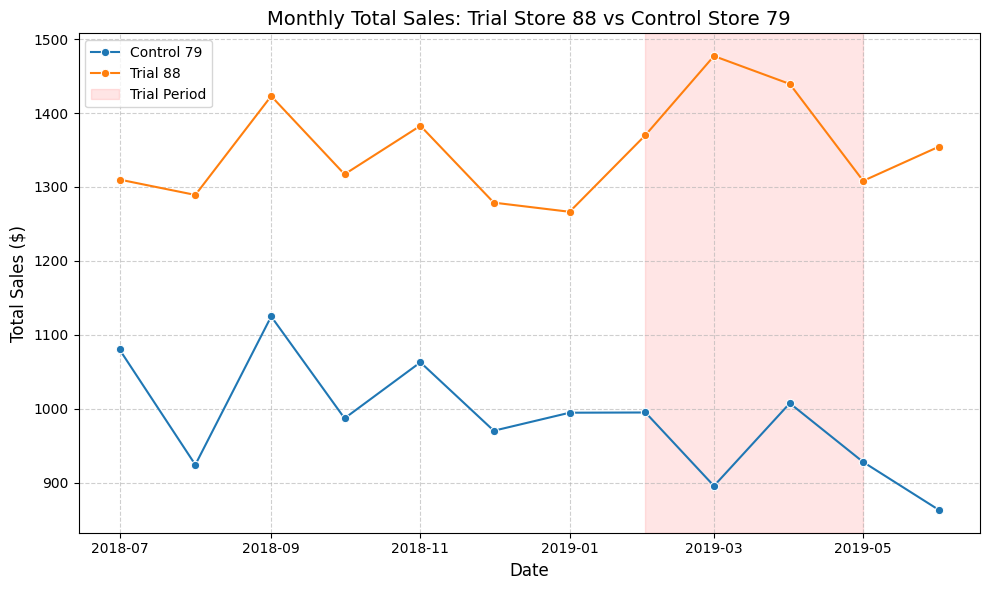

  Sales comparison plot saved as sales_comparison_store_88.png

--- Analysis Complete ---


In [13]:
final_results = {}

print("--- Trial Performance Evaluation (Trial Period: Feb 2019 - Apr 2019) ---")

for trial_store, control_store in control_store_map.items():
    if not control_store:
        continue

    print(f"\n--- Comparing Trial Store {trial_store} vs. Control Store {control_store} ---")

    # 5.1 Isolate Pre-Trial Sales Data for the pair
    pre_trial_sales_trial = store_metrics_monthly[
        (store_metrics_monthly['STORE_NBR'] == trial_store) &
        (store_metrics_monthly['YEAR_MONTH'] <= PRE_TRIAL_END)
    ]['total_sales']

    pre_trial_sales_control = store_metrics_monthly[
        (store_metrics_monthly['STORE_NBR'] == control_store) &
        (store_metrics_monthly['YEAR_MONTH'] <= PRE_TRIAL_END)
    ]['total_sales']

    # 5.2 Perform T-Test on Pre-Trial Data (Baseline Check)
    # This confirms the control and trial stores were statistically similar *before* the trial
    if len(pre_trial_sales_trial) > 1 and len(pre_trial_sales_control) > 1:
        t_stat_pre, p_value_pre = ttest_ind(pre_trial_sales_trial, pre_trial_sales_control, equal_var=False)
        print(f"Pre-Trial T-Test P-Value (Sales): {p_value_pre:.4f}")

        if p_value_pre < 0.05:
            print("  Warning: Pre-trial sales were already statistically different (P < 0.05).")
        else:
            print("  Baseline OK: Pre-trial sales were not statistically different (P > 0.05).")
    else:
        print("  Not enough pre-trial data for T-Test.")


    # 5.3 Isolate Trial Period Sales Data for the pair
    trial_period_metrics = store_metrics_monthly[
        (store_metrics_monthly['YEAR_MONTH'] >= TRIAL_PERIOD_START) &
        (store_metrics_monthly['YEAR_MONTH'] <= TRIAL_PERIOD_END) &
        (store_metrics_monthly['STORE_NBR'].isin([trial_store, control_store]))
    ]

    # Calculate the total sales for trial and control in the trial period
    trial_sales_sum = trial_period_metrics[trial_period_metrics['STORE_NBR'] == trial_store]['total_sales'].sum()
    control_sales_sum = trial_period_metrics[trial_period_metrics['STORE_NBR'] == control_store]['total_sales'].sum()

    # Calculate the normalized change (Trial - Control) / Control
    sales_impact = (trial_sales_sum - control_sales_sum) / control_sales_sum * 100

    print(f"\nTrial Period Sales (3 months):")
    print(f"  Trial Store {trial_store} Sales: ${trial_sales_sum:,.2f}")
    print(f"  Control Store {control_store} Sales: ${control_sales_sum:,.2f}")
    print(f"  SALES IMPACT (Trial vs Control): {sales_impact:+.2f}%")


    # 5.4 Check the Driver of Change (Sales vs Customers vs Frequency)
    # Compare the trial store's metric to the control store's metric during the trial period
    driver_metrics = ['customer_count', 'avg_txns_per_cust']

    for metric in driver_metrics:
        trial_metric_sum = trial_period_metrics[trial_period_metrics['STORE_NBR'] == trial_store][metric].sum()
        control_metric_sum = trial_period_metrics[trial_period_metrics['STORE_NBR'] == control_store][metric].sum()

        metric_impact = (trial_metric_sum - control_metric_sum) / control_metric_sum * 100

        print(f"  {metric.replace('_', ' ').title()} Impact: {metric_impact:+.2f}%")


    # 5.5 Visual Check of Sales Trend (Pre-Trial and Trial Period)
    plt.figure(figsize=(10, 6))

    # Combine the pre-trial and trial data for plotting
    plot_data = store_metrics_monthly[
        store_metrics_monthly['STORE_NBR'].isin([trial_store, control_store])
    ].copy()

    plot_data['Store Type'] = np.where(plot_data['STORE_NBR'] == trial_store, f'Trial {trial_store}', f'Control {control_store}')
    plot_data['YEAR_MONTH_DT'] = plot_data['YEAR_MONTH'].apply(lambda x: x.start_time)

    sns.lineplot(x='YEAR_MONTH_DT', y='total_sales', hue='Store Type', data=plot_data, marker='o')

    # Highlight the trial period
    plt.axvspan(TRIAL_PERIOD_START.start_time, TRIAL_PERIOD_END.end_time, color='red', alpha=0.1, label='Trial Period')

    plt.title(f'Monthly Total Sales: Trial Store {trial_store} vs Control Store {control_store}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Sales ($)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'sales_comparison_store_{trial_store}.png')
    plt.close()
    print(f"  Sales comparison plot saved as sales_comparison_store_{trial_store}.png")

print("\n--- Analysis Complete ---")

## Summary and Insights from Trial Analysis

The objective of this analysis was to evaluate the effectiveness of the trial in stores 77, 86, and 88 by comparing their performance against selected control stores during the trial period (Feb 2019 - Apr 2019).

### Trial Store 77 vs. Control Store 50
- **Pre-Trial Baseline**: The pre-trial sales for Store 77 and its control Store 50 were not statistically different (P-Value: 0.0758), indicating a suitable baseline for comparison.
- **Sales Impact**: Trial Store 77 showed a significant positive sales impact of **+24.54%** compared to its control.
- **Driver of Change**: This sales increase was primarily driven by a **+17.36%** increase in customer count, while the average transactions per customer remained largely stable at **+0.23%**.
- **Insight**: The trial in Store 77 appears to be highly effective, mainly by attracting more unique customers.

### Trial Store 86 vs. Control Store 155
- **Pre-Trial Baseline**: The pre-trial sales for Store 86 and its control Store 155 were not statistically different (P-Value: 0.4836), confirming a valid baseline.
- **Sales Impact**: Trial Store 86 experienced a positive sales impact of **+9.76%** compared to its control.
- **Driver of Change**: The sales growth was largely due to a **+13.54%** increase in customer count, despite a slight decrease of **-2.41%** in average transactions per customer.
- **Insight**: The trial in Store 86 also shows positive results, driven by an increase in customer base.

### Trial Store 88 vs. Control Store 79
- **Pre-Trial Baseline**: A significant concern exists as the pre-trial sales for Store 88 and its control Store 79 were already statistically different (P-Value: 0.0000). This indicates that the control store may not have been an ideal match from the outset, potentially skewing the interpretation of trial results.
- **Sales Impact**: Trial Store 88 showed a substantial sales impact of **+47.95%** compared to its control.
- **Driver of Change**: This impact was driven by a **+32.19%** increase in customer count and a notable **+8.12%** increase in average transactions per customer.
- **Insight**: While Store 88 shows the highest sales growth, the pre-trial baseline issue makes it difficult to definitively attribute this solely to the trial. It's possible that the trial store was already performing significantly better than its chosen control even before the trial began. However, the increase in both customer count and average transactions per customer suggests a strong positive effect if the baseline difference is accounted for.

### Overall Conclusion
Stores 77 and 86 demonstrate clear positive impacts from the trial, primarily by increasing their customer base. Store 88 also shows strong growth in sales and customer metrics, but the statistically different pre-trial baseline raises questions about the validity of the control comparison for this particular store. Further investigation or alternative control selection might be beneficial for Store 88 to confirm the trial's true impact.